In [1]:
import pandas as pd
import numpy as np

In [2]:
df_trans = pd.read_csv("data/LI-Small_Trans.csv")
df_acc = pd.read_csv("data/LI-Small_accounts.csv")

In [3]:
df_acc.head()

,Bank Name,Bank ID,Account Number,Entity ID,Entity Name
0,China Bank #2820,314693,81B86A280,800D8CCF0,Corporation #41344
1,France Bank #4585,311253,8187FEA80,800B505E0,Corporation #54497
2,China Bank #2242,39996,803961E00,800D03F60,Partnership #36904
3,National Bank of Newport,331440,81B075800,801567C10,Corporation #16224
4,UK Bank #33,135417,80CF87C80,801085E00,Partnership #72930


In [4]:
df_trans.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:08,11,8000ECA90,11,8000ECA90,3195403.00,US Dollar,3195403.00,US Dollar,Reinvestment,0
1,2022/09/01 00:21,3402,80021DAD0,3402,80021DAD0,1858.96,US Dollar,1858.96,US Dollar,Reinvestment,0
2,2022/09/01 00:00,11,8000ECA90,1120,8006AA910,592571.00,US Dollar,592571.00,US Dollar,Cheque,0
3,2022/09/01 00:16,3814,8006AD080,3814,8006AD080,12.32,US Dollar,12.32,US Dollar,Reinvestment,0
4,2022/09/01 00:00,20,8006AD530,20,8006AD530,2941.56,US Dollar,2941.56,US Dollar,Reinvestment,0


In [5]:
df_trans.rename(columns={
    'Timestamp': 'timestamp',
    'Account': 'from_acc',
    'From Bank': 'from_bank',
    'To Bank': 'to_bank',
    'Account.1': 'to_acc',
    'Amount Received': 'amount',
    'Receiving Currency': 'curr',
    'Amount Paid': 'amount_paid',
    'Payment Currency': 'curr_paid',
    'Payment Format': 'payment_type',
    'Is Laundering': 'is_laundering',
    }, inplace=True)

In [6]:
df_trans['timestamp'] = pd.to_datetime(df_trans['timestamp'])

df_trans['is_self_tx'] = (df_trans['from_acc'] == df_trans['to_acc']).astype(int)
df_trans['is_cross_bank'] = (df_trans['from_bank'] != df_trans['to_bank']).astype(int)
df_trans['hour'] = df_trans['timestamp'].dt.hour
df_trans['log_amount'] = np.log1p(df_trans['amount'])
df_trans['log_amount_paid'] = np.log1p(df_trans['amount_paid'])
df_trans["cross_currency"] = (df_trans["curr"] != df_trans["curr_paid"]).astype(int)

In [7]:
risk_map = {
    "Cash": "High",
    "Bitcoin": "High",
    "Wire": "Medium",
    "ACH": "Low",
    "Cheque": "Low",
    "Credit Card": "Low",
    "Reinvestment": "Low"
}

df_trans["payment_type_risk"] = df_trans["payment_type"].map(risk_map)

In [8]:
df_trans.head()

,timestamp,from_bank,from_acc,to_bank,to_acc,amount,curr,amount_paid,curr_paid,payment_type,is_laundering,is_self_tx,is_cross_bank,hour,log_amount,log_amount_paid,cross_currency,payment_type_risk
0,2022-09-01 00:08:00,11,8000ECA90,11,8000ECA90,3195403.00,US Dollar,3195403.00,US Dollar,Reinvestment,0,1,0,0,14.977224,14.977224,0,Low
1,2022-09-01 00:21:00,3402,80021DAD0,3402,80021DAD0,1858.96,US Dollar,1858.96,US Dollar,Reinvestment,0,1,0,0,7.528310,7.528310,0,Low
2,2022-09-01 00:00:00,11,8000ECA90,1120,8006AA910,592571.00,US Dollar,592571.00,US Dollar,Cheque,0,0,1,0,13.292228,13.292228,0,Low
3,2022-09-01 00:16:00,3814,8006AD080,3814,8006AD080,12.32,US Dollar,12.32,US Dollar,Reinvestment,0,1,0,0,2.589267,2.589267,0,Low
4,2022-09-01 00:00:00,20,8006AD530,20,8006AD530,2941.56,US Dollar,2941.56,US Dollar,Reinvestment,0,1,0,0,7.987035,7.987035,0,Low


In [9]:
df_trans["in_degree"] = df_trans.groupby("to_acc")["from_acc"].transform("nunique")
df_trans["out_degree"] = df_trans.groupby("from_acc")["to_acc"].transform("nunique")


In [10]:

df_trans["stack_degree_flag"] = (
    (df_trans["in_degree"] == 1) &
    (df_trans["out_degree"] == 1)
).astype(int)

df_trans = df_trans.sort_values("timestamp")

df_trans["time_since_prev_tx"] = (
    df_trans
        .groupby("from_acc")["timestamp"]
        .diff()
        .dt.total_seconds() / 3600
)

df_trans["amount_ratio_prev"] = (
    df_trans
        .groupby("from_acc")["amount"]
        .transform(lambda x: x / x.shift(1))
        .replace([np.inf, -np.inf], np.nan)
)

df_trans["returns_to_origin"] = (
    df_trans["to_acc"].isin(df_trans["from_acc"])
).astype(int)

df_trans["account_seen_before"] = (
    df_trans.groupby("from_acc").cumcount() > 0
).astype(int)

df_trans["currency_change"] = (
    df_trans["curr"] !=
    df_trans.groupby("from_acc")["curr"].shift()
).astype(int)

df_trans["fanin_degree"] = (
    df_trans
        .groupby(["to_acc", df_trans["timestamp"].dt.date])["from_acc"]
        .transform("nunique")
)

df_trans["fanin_amount_sum"] = (
    df_trans
        .groupby(["to_acc", df_trans["timestamp"].dt.date])["amount"]
        .transform("sum")
)

df_trans["fanin_flag"] = (df_trans["fanin_degree"] >= 3).astype(int)

df_trans["fanout_degree"] = (
    df_trans
        .groupby(["from_acc", df_trans["timestamp"].dt.date])["to_acc"]
        .transform("nunique")
)

df_trans["gather_scatter_flag"] = (
    (df_trans["fanin_degree"] >= 3) &
    (df_trans["fanout_degree"] >= 3)
).astype(int)

df_trans["same_payment_type_chain"] = (
    df_trans["payment_type"] ==
    df_trans.groupby("from_acc")["payment_type"].shift()
).astype(int)


In [11]:
df_trans.head()

,timestamp,from_bank,from_acc,to_bank,to_acc,amount,curr,amount_paid,curr_paid,payment_type,...,amount_ratio_prev,returns_to_origin,account_seen_before,currency_change,fanin_degree,fanin_amount_sum,fanin_flag,fanout_degree,gather_scatter_flag,same_payment_type_chain
12231,2022-09-01,1807,801321C30,1807,801321C30,220579.84,US Dollar,220579.84,US Dollar,Reinvestment,...,NaN,1,0,1,2,226568.37,0,5,0,0
225844,2022-09-01,129759,80DBF72D0,129759,80DBF72D0,34167.89,Euro,34167.89,Euro,Reinvestment,...,NaN,1,0,1,3,37610.50,1,3,1,0
42017,2022-09-01,22086,806636010,22086,806636010,24.63,US Dollar,24.63,US Dollar,Reinvestment,...,NaN,1,0,1,1,45.86,0,1,0,0
344938,2022-09-01,29,80C66BDE0,29,80C66BDE0,0.48,UK Pound,0.48,UK Pound,Reinvestment,...,NaN,1,0,1,2,1033.20,0,1,0,0
162624,2022-09-01,19085,8081D8EE0,137029,81B71B370,16077.82,US Dollar,16077.82,US Dollar,Credit Card,...,NaN,1,0,1,3,13190952.91,1,3,1,0


In [15]:
df_trans.groupby("is_laundering")[
    ["fanin_flag", "gather_scatter_flag", "currency_change"]
].mean()


,fanin_flag,gather_scatter_flag,currency_change
is_laundering,,,
0,0.150756,0.071885,0.106627
1,0.348387,0.075456,0.132959


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# pick numeric columns only
num_cols = df_trans.select_dtypes(include=["int64", "float64"]).columns

corr = df_trans[num_cols].corr()

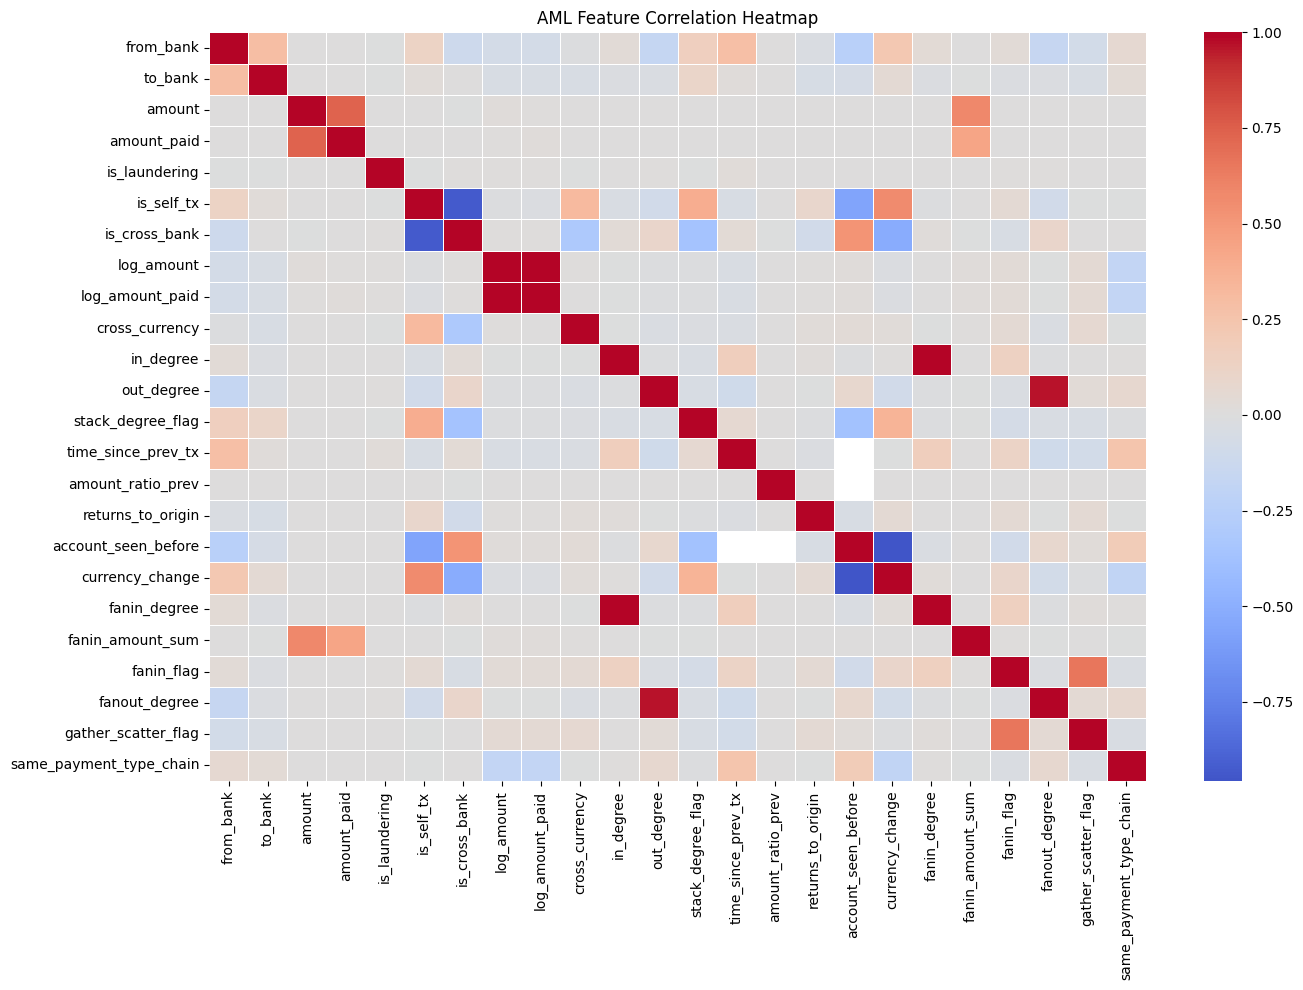

In [13]:
plt.figure(figsize=(14, 10))

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False,
    linewidths=0.5
)

plt.title("AML Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

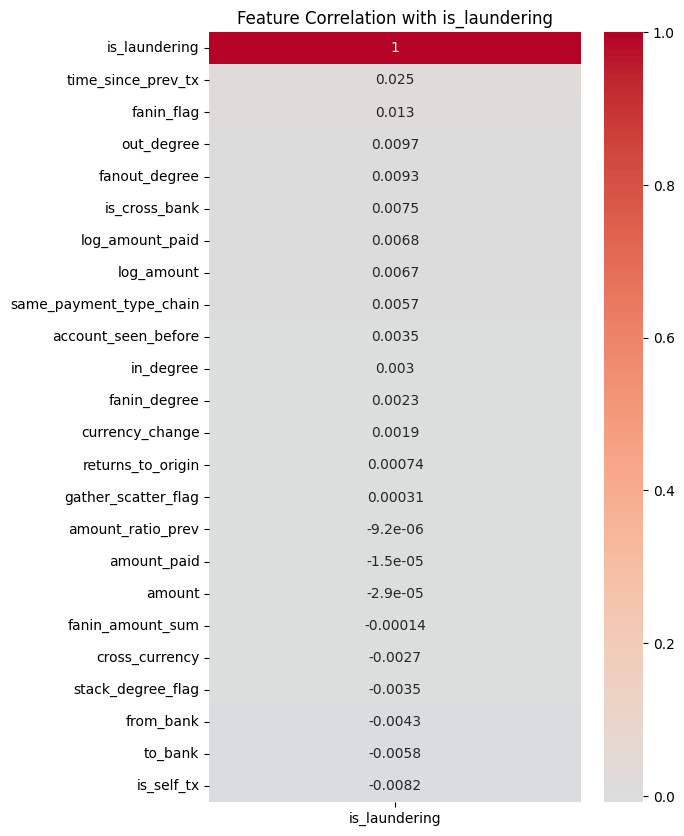

In [14]:
laundering_corr = (
    corr["is_laundering"]
    .sort_values(ascending=False)
    .to_frame()
)

plt.figure(figsize=(6, 10))
sns.heatmap(
    laundering_corr,
    annot=True,
    cmap="coolwarm",
    center=0
)

plt.title("Feature Correlation with is_laundering")
plt.show()


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    "fanin_flag": [0.150756, 0.348387],
    "gather_scatter_flag": [0.071885, 0.075456],
    "currency_change": [0.106627, 0.132959]
}

df_heat = pd.DataFrame(
    data,
    index=["Non-Laundering (0)", "Laundering (1)"]
)


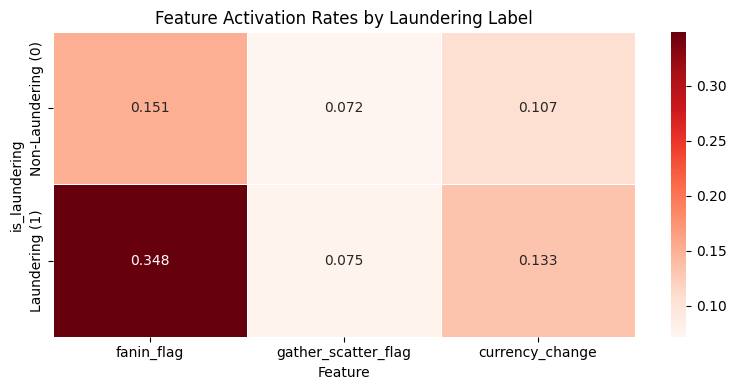

In [17]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    df_heat,
    annot=True,
    fmt=".3f",
    cmap="Reds",
    linewidths=0.5
)

plt.title("Feature Activation Rates by Laundering Label")
plt.ylabel("is_laundering")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()
